In [34]:
from pandas import read_csv, DataFrame
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd

from base.pandas_constants import AlgorithmConstants, DataFrameConstants


In [35]:
df = read_csv(AlgorithmConstants.FINAL_DF_PATH)
df.head()

df = df[df[DataFrameConstants.DANGER_LEVEL] != 'Baixa']

In [36]:
df.describe()

,latitude,longitude,rain_day,rain_hour,elevation
count,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000
mean,-8.034787,-34.930820,15.314634,0.658018,47.235599
std,0.052360,0.017891,19.046952,1.286009,16.238344
min,-8.140337,-34.979501,0.000000,0.000000,7.000000
25%,-8.086452,-34.945819,3.650000,0.100000,35.000000
50%,-8.009220,-34.929010,9.600000,0.200000,47.000000
75%,-8.000093,-34.917472,19.100000,0.600000,60.000000
max,-7.961544,-34.886717,83.000000,8.300000,90.000000


In [37]:
label_encoders = {}
categorical_columns = [
    DataFrameConstants.GROUND_TYPE,
    DataFrameConstants.GROUND_AMPLITUDE,
    DataFrameConstants.SLOPE_DEGREE,
    DataFrameConstants.SLOPE_PERCENTAGE,
    DataFrameConstants.DANGER_LEVEL
]

numerical_columns = [
    DataFrameConstants.RAIN_DAY,
    DataFrameConstants.RAIN_HOUR,
    DataFrameConstants.ELEVATION,
    DataFrameConstants.LATITUDE,
    DataFrameConstants.LONGITUDE
]

df_encoded = df.copy()

for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    df_encoded[column] = label_encoders[column].fit_transform(df_encoded[column])

features = df_encoded[numerical_columns + categorical_columns]
print(features)

      rain_day  rain_hour  elevation  latitude  longitude  ground_type  \
1          3.8        1.0       23.0 -7.998090 -34.921421            3   
2         10.3        0.2       51.0 -8.116982 -34.951488            2   
5          9.2        0.4       43.0 -8.004813 -34.908961            5   
6          9.6        0.6       53.0 -8.002648 -34.908863            3   
7          9.2        0.4       25.0 -8.001664 -34.903260            3   
...        ...        ...        ...       ...        ...          ...   
2946      83.0        0.1       25.0 -7.991705 -34.926515            3   
2949      20.2        0.0       69.0 -8.137449 -34.931980            2   
2950      35.6        0.3       32.0 -7.999622 -34.928184            3   
2951      12.7        1.1       79.0 -7.995187 -34.929967            3   
2952      12.7        0.6       86.0 -7.999551 -34.935512            3   

      ground_amplitude  slope_degree  slope_percentage  danger_level  
1                    2             1    

In [38]:
best_k = 0
best_inertia = None
best_columns = None
best_config = None

range_clusters = list(range(1, 30))
random_states = list(range(0, 64))

max_iters = [300, 500, 1000]
algorithms = ['lloyd', 'elkan']
best_k_means = None

In [39]:
scaler = StandardScaler()


df_to_be_scaled = df_encoded
df_scaled = scaler.fit_transform(df_to_be_scaled)

DataFrame(df_scaled).describe()


,0,1,2,3,4,5,6,7,8,9
count,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03
mean,-3.731548e-15,5.092014e-13,1.327428e-16,-1.253682e-16,-3.097332e-16,-1.253682e-16,5.899680e-17,1.474920e-17,-1.474920e-17,-1.843650e-18
std,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00
min,-2.016389e+00,-2.721776e+00,-1.567680e+00,-1.123107e+01,-5.030572e+00,-1.123107e+01,-3.023591e+00,-8.042552e-01,-5.118072e-01,-2.478457e+00
25%,-9.869897e-01,-8.386258e-01,-2.160383e-01,1.685992e-01,9.576975e-02,1.685992e-01,3.307325e-01,-6.125737e-01,-4.340270e-01,-7.536960e-01
50%,4.884230e-01,1.011687e-01,4.597828e-01,1.685992e-01,9.576975e-02,1.685992e-01,3.307325e-01,-3.001067e-01,-3.562469e-01,-1.451260e-02
75%,6.627827e-01,7.462511e-01,4.597828e-01,1.685992e-01,9.576975e-02,1.685992e-01,3.307325e-01,1.987903e-01,-4.512622e-02,7.862694e-01
max,1.399199e+00,2.465748e+00,1.811425e+00,1.685992e-01,5.222112e+00,1.685992e-01,3.307325e-01,3.554529e+00,5.943946e+00,2.634228e+00


In [40]:
SSE = []
results = []

for num_clusters in range_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++')
    kmeans.fit(df_scaled)
    inertia = kmeans.inertia_
    SSE.append(inertia)
    print(f'Inertia: {inertia}')
    if best_inertia is None or inertia < best_inertia:
        best_k = num_clusters
        best_k_means = kmeans
        best_inertia = kmeans.inertia_
        best_columns = features.columns.tolist()

print(f'Best K: {best_k}, Best Inertia: {best_inertia}')

Inertia: 19270.0
Inertia: 14019.561698833984
Inertia: 15493.95399559396
Inertia: 9262.362586612555
Inertia: 7922.885006860718
Inertia: 6463.247144786388
Inertia: 7081.28421426289
Inertia: 5540.05533945466
Inertia: 5213.366243179967
Inertia: 5048.321240397304
Inertia: 4600.686559969128
Inertia: 4288.305329941
Inertia: 4144.0360485872025
Inertia: 3637.854197974615
Inertia: 3525.782290135116
Inertia: 3606.24370165224
Inertia: 3414.132396507178
Inertia: 3195.414434621513
Inertia: 3133.895993853348
Inertia: 3016.959979614402
Inertia: 2906.6822336094233
Inertia: 2808.1710692957986
Inertia: 2660.0747024659877
Inertia: 2599.344882030699
Inertia: 2548.073085750182
Inertia: 2495.3720866515696
Inertia: 2432.9940904703403
Inertia: 2385.4620480208314
Inertia: 2271.8111915480954
Best K: 29, Best Inertia: 2271.8111915480954


Text(0, 0.5, 'Inertia')

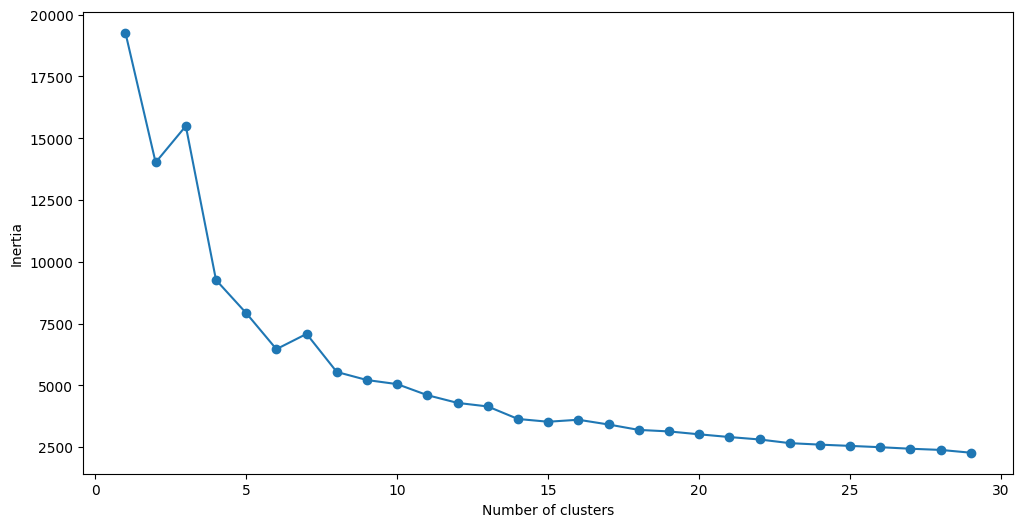

In [41]:
frame = DataFrame({'Cluster':range(1, 30), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')


In [42]:
kmeans = KMeans(n_clusters=8, init='k-means++') # Using elbow curve
kmeans.fit(df_scaled)
print(f'Inertia: {kmeans.inertia_}')   
pred = kmeans.predict(df_scaled)

Inertia: 5603.8338165804935


In [43]:
df[DataFrameConstants.CLUSTER] = pred

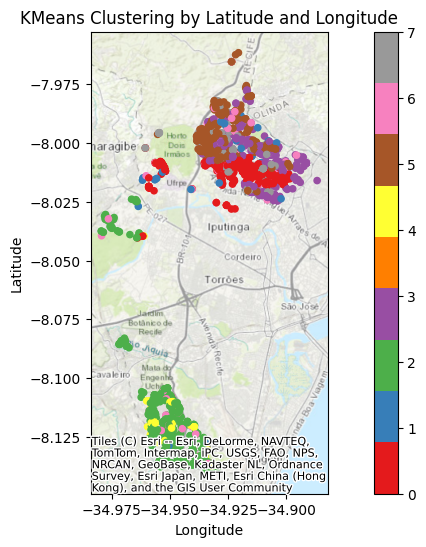

In [44]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df[DataFrameConstants.LONGITUDE], df[DataFrameConstants.LATITUDE])
)

# Set a CRS (Coordinate Reference System) for the GeoDataFrame (e.g., WGS84)
gdf.set_crs(epsg=4326, inplace=True)

# Plotting with map background
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the GeoDataFrame on the ax
gdf.plot(ax=ax, column=DataFrameConstants.CLUSTER, cmap='Set1', markersize=20, legend=True)

# Add a basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldTopoMap)

# Customize plot appearance
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('KMeans Clustering by Latitude and Longitude')

plt.show()


In [45]:
df.to_csv('kmeans.csv', index=False, header=True)

In [46]:
df.head()

,latitude,longitude,ground_type,ground_amplitude,slope_degree,slope_percentage,danger_level,rain_day,rain_hour,elevation,cluster
1,-7.998090,-34.921421,LVd4,20 a 100m,10 a 30º,0 a 60%,Media,3.8,1.0,23.0,3
2,-8.116982,-34.951488,LVd2,20 a 100m,10 a 30º,0 a 60%,Media,10.3,0.2,51.0,2
5,-8.004813,-34.908961,URBANO,20 a 100m,10 a 30º,0 a 60%,Media,9.2,0.4,43.0,3
6,-8.002648,-34.908863,LVd4,20 a 100m,10 a 30º,0 a 60%,Media,9.6,0.6,53.0,5
7,-8.001664,-34.903260,LVd4,20 a 100m,10 a 30º,0 a 60%,Media,9.2,0.4,25.0,3
